# Benchmarking imputation methods on the implementation of GRU to forecast Mendota lake’s epilimnetic phosphorus.

-WARNING: This notebook take at least 4 hours to run

How do different imputation methods affect the lake’s phosphorus forecasting performance of a GRU-rnn model?

### Necessary packages

In [1]:
# Common imports
import glob
import random
import os
import re
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)# Avoid print error

from datetime import datetime
import numpy as np 
from numpy.random import seed
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.mode.chained_assignment = None # avoid error 
pd.options.display.float_format = '{:.5f}'.format # No scientific annotation when print dataframe
from functools import reduce
  
# ADA and Modeling imports
import math
import sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error, accuracy_score
from IPython.display import clear_output

from scipy.stats import stats
import tensorflow as tf
from tensorflow import keras
from tsmoothie.smoother import *

# To plot pretty figures
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Build function
from HelperFunctions import *
from Implementation import *

# To generate an stable output across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# MAchine learing packages 
import tensorflow 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics 
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.activations import selu,elu,relu,tanh
from tensorflow.keras.initializers import RandomNormal

from keras import Input #
from keras.models import Sequential, load_model
import keras.backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, LSTM, GRU, InputLayer, Flatten, Conv1D, Activation

n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 16


In [ ]:
LakeConfig, pars,HydroSource,StratSource,HypoSource = ModelConfig(2)
StratData, dataseq = DataPreparation_Mendota(StratSource)
Inflow =  GetInFlow(StratData.index,HydroSource)
HypsoME,NewHypso,obsCDEpi,obsCDHypo,PeakDates,PeakEpi,PeakHypo=  GetLakeData(HypoSource)

pars = ( 0.0141929, 22.8315205,  1.0651408,  1.1718688)

Pepi,Phyp,Psed= MechanisticModels(LakeConfig,pars,HydroSource,StratSource,HypoSource,StratData,Inflow,HypsoME,NewHypso,obsCDEpi,obsCDHypo,PeakDates,PeakEpi,PeakHypo)


In [ ]:
def Volume_calc(NewHypso,LakeConfig,StratData,dataseq):
    #### Lake Config Values ####
    MeanDepth = (LakeConfig.MeanDepth).item() #m
    # nex line is to generate a variable with the same value (25) but with a len of obsTherm to not get error in calculation
    zm = (LakeConfig.zm).item()#max depth in m
    LakeArea = (LakeConfig.LakeArea).item() #m2
    MeanDepth = (LakeConfig.MeanDepth).item() #m
    LakeVolume = (LakeArea* MeanDepth)
    
    if HypsoME.Hypso_cum.values is None:
        
        obsTherm = pd.DataFrame(round(StratData['Therm'], 1))
        # [0] -> to just grab the first value of zm and not get and error for doing math with variables with diff shape
        A = ((3*((2*(MeanDepth/zm))-1))*(((zm-obsTherm.Therm)/zm)**2)) - ((2*((3*(MeanDepth/zm))-2))*((zm-obsTherm.Therm)/zm))
        V = (((zm-obsTherm.Therm)/zm)+(((3*(MeanDepth/zm))-2)*(((zm-obsTherm.Therm)/zm)**2))-((2*(MeanDepth/zm))-1)*(((zm-obsTherm.Therm)/zm)**3))/((MeanDepth/zm))
        V = 1-V
    else:
        
        obsTherm = pd.DataFrame(round(StratData['Therm'], 1))
        # Reset index to have the original index of each data frame to then extract the index in which both match
        NewHypso.reset_index(inplace = True)
        NewHypso['depth'] = round(NewHypso['depth'], 1)

        obsTherm.reset_index(inplace = True) # x2 reset in StratData since the 1st takeout sampledate from index and
        obsTherm.reset_index(inplace = True) # 2nd reset to pass the original index as a column to then match

        # Mask to find  the index position in which the Thermocline depth match with depth of hypso -> index_x
        mask =  pd.merge(obsTherm,NewHypso, left_on='Therm', right_on='depth', how = 'left')['index_y']
        V = NewHypso.Hypso_cum.iloc[mask].values
        
    # Calculate epi and hypo volume vectors, which should always add up to lake volume
    HypV = (LakeVolume * (1-V))# hypolimnetic volume time series
    EpiV = LakeVolume-HypV
    
    df = pd.DataFrame({'HypV':HypV, 'EpiV':EpiV})
    df.index = dataseq.index
    return(df)
    


In [ ]:
volume = (Volume_calc(NewHypso,LakeConfig,StratData,dataseq))
obsCDEpi.rename(columns ={'totpuf_sloh':'ObsPepi'},inplace = True)
obsCDEpi.set_index('sampledate',inplace = True)
obsCDHypo.rename(columns ={'totpuf_sloh':'ObsPhyp'}, inplace = True)
obsCDHypo.set_index('sampledate',inplace = True)
Inflow.rename(columns = {'P.g.day':'PLoad','Discharge.m3.d':'Discharge'},inplace = True)

MM_P = (pd.DataFrame({'sampledate':dataseq.index,'Pepi':Pepi/volume.EpiV, 'Phyp':Phyp/volume.HypV})).set_index('sampledate')
MM_P.rename(columns = {'Pepi':'MM_Pepi','Phyp':'MM_Phyp'},inplace = True)

In [ ]:
# Interpolating observed values to be daly bases from the intilal date to the final date 
obsCDEpi_int = pd.merge(obsCDEpi,dataseq,how = 'right',left_index=True, right_index=True)
obsCDEpi_int.interpolate(method='linear', axis=0, inplace=True)
obsCDHypo_int = pd.merge(obsCDHypo,dataseq,how = 'right',left_index=True, right_index=True)
obsCDHypo_int.interpolate(method='linear', axis=0, inplace=True)

In [ ]:
# compile the list of dataframes you want to merge
dfs = [volume, obsCDEpi_int, obsCDHypo_int,StratData,Inflow,MM_P]

df_merged =reduce(lambda a, b: pd.merge(a, b, on='sampledate', how='outer'), dfs)

df_Pepi = (df_merged[df_merged['ObsPepi'].notnull()]).drop(['ObsPhyp','MM_Phyp'], axis =1)
df_Phyp  = df_merged[df_merged['ObsPhyp'].notnull()].drop(['ObsPepi','MM_Pepi'], axis =1)
#df[['EpiTemp','HypoTemp','Strat','Therm','EpiV','HypV','Discharge','PLoad','ObsPepi','ObsPhyp']]
#

#
df_Pepi= df_Pepi[['EpiTemp','HypoTemp','Strat','Therm','EpiV','HypV','Discharge','PLoad','ObsPepi','MM_Pepi']]
df_Phyp= df_Phyp[['EpiTemp','HypoTemp','Strat','Therm','EpiV','HypV','Discharge','PLoad','ObsPhyp','MM_Phyp']]

In [ ]:
df = df_Pepi.copy()
df.PLoad[(df.index > '1997-11-01') & (df.index < '1999-11-01')] = np.nan
plt.plot(df.PLoad)

In [ ]:
{'n_seasons': 20,
 'n_longseasons': 65,
 'component_noise': {'level': 0.9311034482758621,
  'longseason': 1.631578947368421,
  'season': 0.7374736842105264,
  'trend': 0.4293571428571429},
 'component': 'level_trend_season_longseason'}

In [ ]:
### OPERATE SMOOTHING ###

smoother = KalmanSmoother(component='level_trend_season_longseason', n_longseasons= 900,n_seasons= 24,
                          component_noise={'level': 0.9,'longseason': 1.631578947368421,'season':0.7374736842105264,'trend': 0.4293571428571429})
smoother.smooth(df.PLoad)

### COMPARE RECONSTRUCTION WITH ORIGINAL ###

plt.figure(figsize=(7,5))
plt.plot(smoother.smooth_data.T, c='blue')
#plt.plot(smoother.data.T, c='orange')
np.set_printoptions(False)

In [ ]:
####OPERATE SMOOTHING ###

smoother = KalmanSmoother(component='level_season', n_seasons=20,
                          component_noise={'level':0.5,'season':0.01})
smoother.smooth(df.PLoad)

### COMPARE RECONSTRUCTION WITH ORIGINAL ###

plt.figure(figsize=(7,5))
plt.plot(smoother.smooth_data.T, c='blue')
plt.plot(smoother.data.T, c='orange')
np.set_printoptions(False)

In [ ]:
import sklearn 
from sklearn  import *
y_train = df_Pepi.PLoad.copy() # Without   y - true label 

In [ ]:
def score(data, targets): # targets == data?
        return sklearn.metrics.mean_absolute_error( targets, (data) )

In [ ]:
score(y_train,smoother.smooth_data.T)

## Imputation method

 TS_feature: EpiTemp, bottom_index:1492, upper_index:2590, nan_len:1098
 TS_feature: HypoTemp, bottom_index:315, upper_index:1281, nan_len:966
 TS_feature: Therm, bottom_index:5243, upper_index:6124, nan_len:881
 TS_feature: EpiV, bottom_index:3209, upper_index:4088, nan_len:879
 TS_feature: HypV, bottom_index:3105, upper_index:4186, nan_len:1081
 TS_feature: Discharge, bottom_index:26, upper_index:827, nan_len:801
 TS_feature: PLoad, bottom_index:1000, upper_index:2067, nan_len:1067


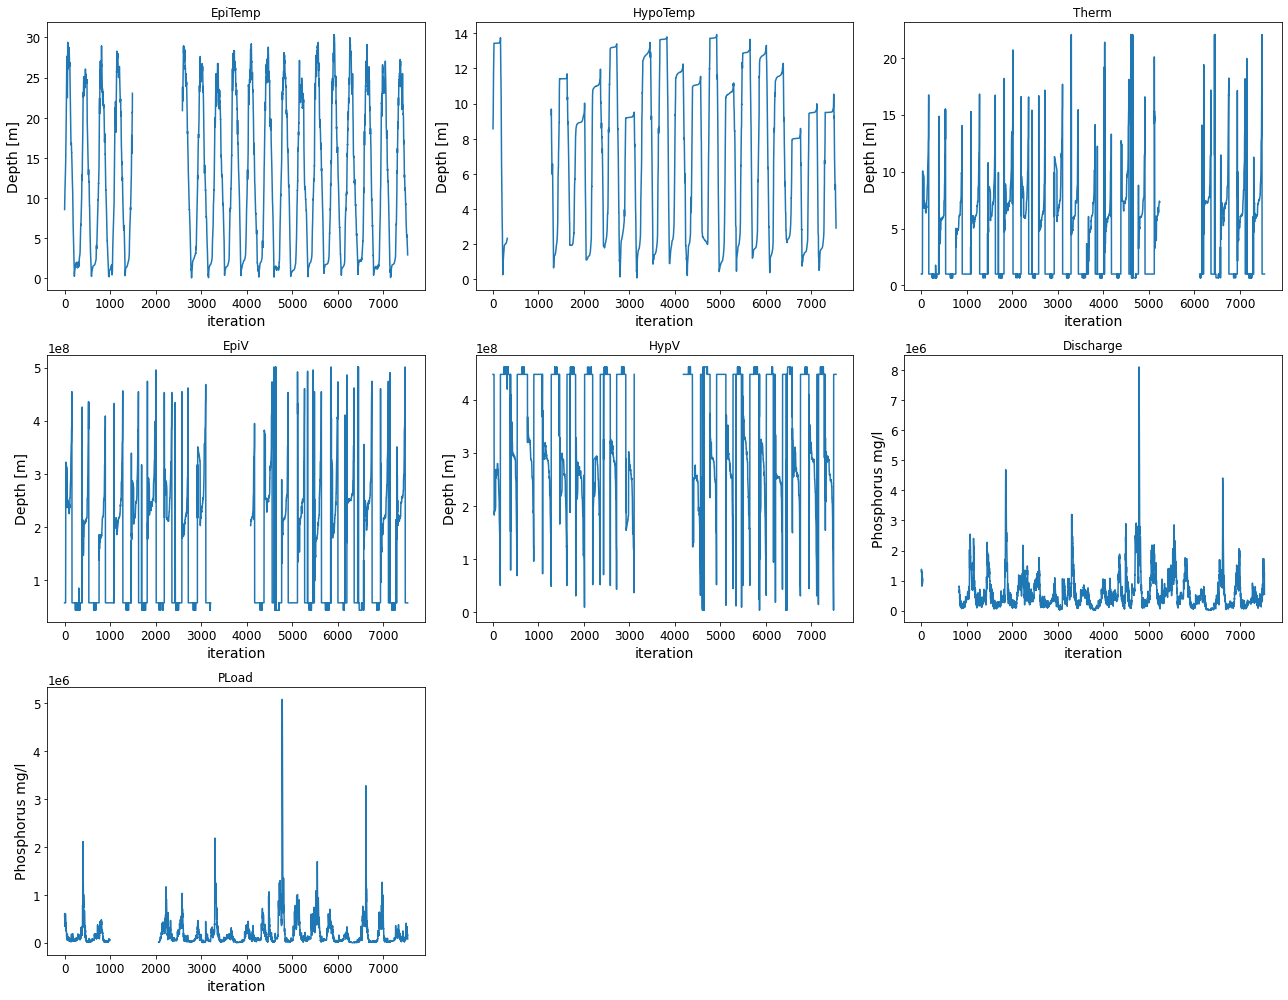

In [58]:
# Importing data 
y_train = pd.read_csv('Pepi_Mendota.csv')
y_train['sampledate'] = pd.to_datetime(y_train['sampledate'])

X_train = y_train.copy()

def Nan_windows(data, plot):
    ''' 
    
    'Generate nan window with random length and index position, 
    to then apply it each timeseries feature (X) of the data'
    
    Arguments
    
    data: Dataframe with only features (X) 
    
    plot: Boolean argument (True: print timeserie with the nan values artifically induced)
        
    ''';
    
    # drop the date as index, and replace it with a numeric one
    if data.index.dtype == '<M8[ns]': # Do it only if data type of index is datatime
        data.reset_index(inplace=True) 
        
    n_c = 0 # number of coulmns used (+1 after each iteration)
    
    for i in data.columns[1:9]: # For each timeseries feature (X) in the dataframe
        if data[i].dtype == 'float64': # filter only numeric variables (in this case all numeric are float64)
            
            # Initilize the index position of the windows
            upper_limit = []
            bottom_limit = [] 
            
            max_days = data.shape[0]-342 # -342 to eliminate last rows with weird data
            min_days = 0

            # Random percentage of the data to be missing
            perc_missing =random.uniform(0.1, 0.15) # between 10% and 15% 

            # Random data windows be imputed with Nan's (min:754 max:1131.0)
            na_window = int(data.shape[0]*perc_missing) 
            
            # Generate a random upper index position up to the nan is found
            ''' Note: the upper index has to be = or < to the len to go out of index bound''';
            upper_limit = random.randint(na_window,max_days) 

            # The bottom index position is just the window's lenght distance from the upper position  
            bottom_limit = upper_limit-na_window

            # Replace data with nan at the generated index position
            data[i][bottom_limit:upper_limit] = np.nan 
            
            # Update the number of column used
            n_c += 1
            
            print(f' TS_feature: {i}, bottom_index:{bottom_limit}, upper_index:{upper_limit}, nan_len:{na_window}')       

    if plot == True: # If any argument is pass as input for 'plot' then:
        # plot the nan_windows for each feature (X)
                
        count = 1
        fig,ax = plt.subplots(figsize=(18,14))
        

        for i in data.columns[1:9]:
            if data[i].dtype == 'float64':
                plt.subplot(int(n_c/2),int(n_c/2),count)
                plt.plot(data[i])
                plt.xlabel(f'iteration')
                plt.title(f'{i}')
                count+=1
                if count <= 6:
                    plt.ylabel('Depth [m]')
                else:
                    plt.ylabel('Phosphorus mg/l')
                    
    fig.tight_layout()
    plt.show()
    return(data)
        

X_train = Nan_windows(X_train,True)

### Kalmansmooth interpolation

#### Kalmansmooth hyperparamters to explore

To find the best KTS imputation method we need to generate a grid search considering the following parameters and range of values

In [11]:
library("IRdisplay")
display_png(file = "KTSgrid.png", width = 600, height = 300)

NameError: name 'library' is not defined

Let's generate the Parameter Grid for KTS

In [4]:
from sklearn.model_selection import ParameterGrid

grid = { #Noie
        'level':np.linspace(0.01,1.2,25),#.astype('int32'), 
        'trend':np.linspace(0.01,1.2,20),#.astype('int32'),
        'season':np.linspace(0.01,1.2,25),#.astype('int32'),
        'longseason':np.linspace(0.3,5,20)#.asty    pe('int32')
        }

component = ['level', 'level_trend',
    'level_season', 'level_trend_season', 'level_longseason',
    'level_trend_longseason', 'level_season_longseason',
    'level_trend_season_longseason']

n_seasons =np.linspace(20,30,10).astype('int32')
n_longseasons=np.linspace(90,800,100).astype('int32') # np.linspace(1,100,50).astype(int)

param_grid ={'component': component,
              'n_seasons':n_seasons,
             'n_longseasons':n_longseasons,
             'component_noise': list(ParameterGrid(grid))}

#### Kalmansmooth class

Since KTS does not form part of Sklearn, it is necessary to build a class method to apply a Randomized search on the parameter grid by considering the mean absolute error between the observed value and predicted value limited to the windows nan values of each feature

In [5]:
from sklearn.metrics import make_scorer

def rmse_loss(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true))) 
  
rmse = make_scorer(rmse_loss, greater_is_better=False)

import sklearn
class Kalman_TS(sklearn.base.BaseEstimator):
    
    def __init__(self,component = 'level', n_seasons = 10, component_noise = {'level': 0.01,'trend':0.01,'season':0.01,'longseason':0.3}, n_longseasons =90):
        self.component = component 
        self.n_seasons = n_seasons
        self.n_longseasons = n_longseasons
        self.component_noise =  component_noise
        
                      
    def fit(self,X_t, tragets):        
        self.smoother = KalmanSmoother(component=self.component,n_seasons = self.n_seasons, n_longseasons = self.n_longseasons,component_noise = self.component_noise)
        self.smoother.smooth(X_t)

    def predict(self, X_t):
        return self.smoother.smooth_data.T
        #np.maximum(0,self.smoother.smooth_data.T) 
        # [np.maximum]: set negative imputation values to 0 to punish it mse afterwards.

    def score(self, X_t, y_t): 
        return (sklearn.metrics.mean_absolute_error( y_t[tuple(Na)], self.predict(X_t)[tuple(Na)] )) # Metric calculated on nan window  
        # [tuple(Na)]: represent the index position where the na values originally are located    
        # objective: mse compare only the imputated part since he Kalmanmethod only work and output on that
        

#### Kalmansmooth imputation

With the Kalman smoother class built, we can no apply randomized search that produce the best imputation method for each feature of the data

In [6]:

# Initiliye the KTS method
KTS = RandomizedSearchCV(Kalman_TS(),param_grid, cv = [(slice(None),slice(None))],n_jobs=n_cpu-1, n_iter = 100
                         , scoring = 'neg_mean_absolute_error')


# Filter the columns that can be interpolated (features with numeric values)

n_c = 0 # Save number of column that can be imputated
columns = [] # Save columns name that can be imputated
for i in X_train.columns[1:9]:     
    if X_train[i].dtype == 'float64':
        columns.append(i)
        n_c +=1

# KS interpolation For each timeseries feature (X) in the dataframe (df)

X_KTS = X_train.copy()
for idx , i in enumerate(columns):
    exec(f'X_t_{i} = X_train[i].values') #X_train for each varaible as 'X_t_' + '{i}' (variable name)
    exec(f'y_t_{i} = y_train[i].values') #y_train for each varaible as 'y_t_' + '{i}' (variable name)
    temp = eval('X_t_'+i) # placeholder for X_t_{i} values
    
    exec(f'Na_{i} = list(map(tuple, np.where(np.isnan(temp))))') #Save Index array position of missing values for df's features 
    Na = list(map(tuple, np.where(np.isnan(eval('X_t_'+i))))) #Index array position of missing values values for df's features 
    
    KTS.fit(eval('X_t_'+i), y = eval('y_t_'+i)) 
    exec(f'KTS_{i} = KTS.best_params_') #Best parameters as 'KTS_' + '{i}' (variable name)
    smoother = KalmanSmoother(component= (eval('KTS_'+i))['component']
                  ,n_seasons = (eval('KTS_'+i))['n_seasons']
                  ,n_longseasons= (eval('KTS_'+i))['n_longseasons']
                  ,component_noise = (eval('KTS_'+i))['component_noise'])
    
    smoother.smooth(eval('X_t_'+i))
    exec(f'X_pred_{i} = abs(smoother.smooth_data.T)') #KTS imputation learned as 'X_pred_' + '{i}' (variable name)
    exec(f'X_KTS.{i} = X_pred_{i}') # Save each imputation in dataframe
    
    #Verbose
    print(f'X_pred_{i}:  DONE',f'    [{idx+1} out of {n_c} features]',)    
    clear_output(wait=True)
    
clear_output(wait=True) 
print('KTS imputation done')
                  

KTS imputation done


Save the obtained KTS imputation method for each feature as a dataframe call: X_KTS.csv

In [33]:
for idx , i in enumerate(columns):
    df = eval('KTS_'+i) # 
    inx = 'index'
    cn = {0:'KTS_'+i}
    name = 'KTS_'+i+'.csv'
    #exec(f'df_KTS_{i} = (pd.DataFrame.from_dict(data=df, orient=inx).rename(columns = cn)).to_csv(name)')
    #X_KTS.to_csv('X_KTS.csv', index = False, encoding='utf-8')

Plot the imputated data vs original data at the Na index position 

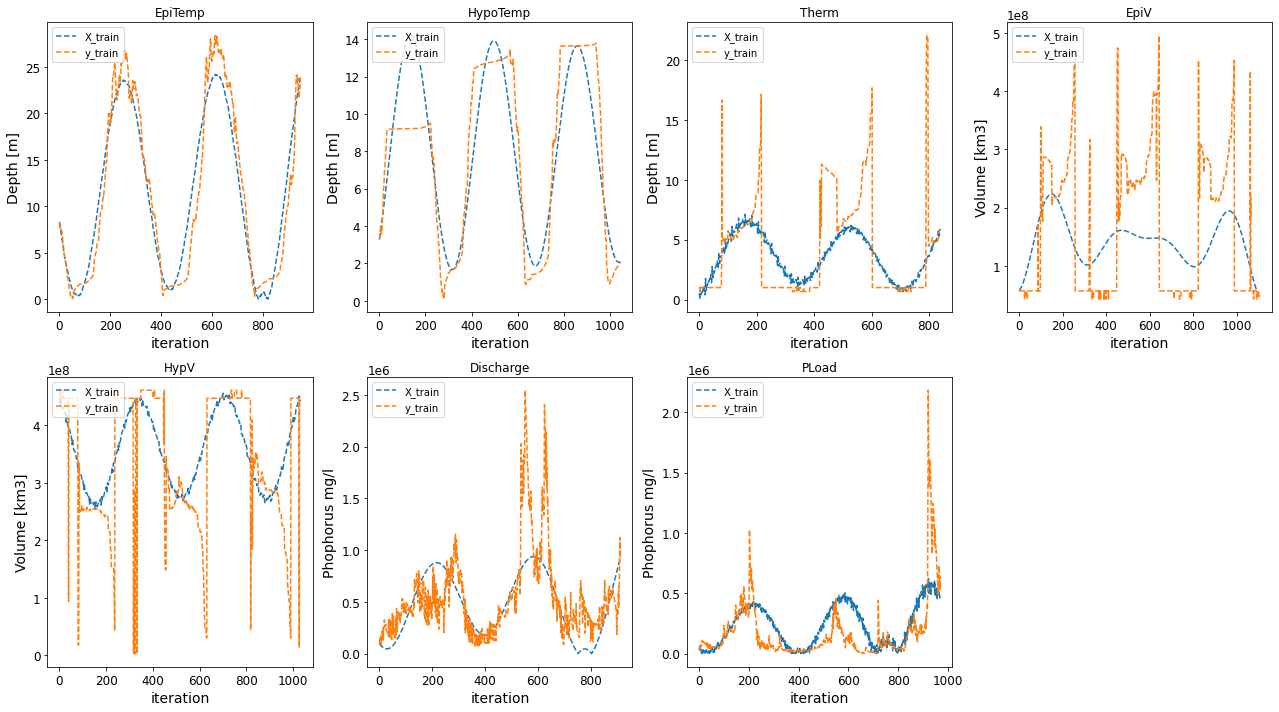

In [60]:
y_train = pd.read_csv('Pepi_Mendota.csv')
count= -1 
metrics = [] # Save imputation performance for the Na section for each column

fig, axs = plt.subplots(2,4, figsize=(18, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

# Plot KTS imputation for each featur limited to the nan window
for i in columns:
    count += 1
    exec(f'X_t = X_KTS.{i}.values') # feature imputed by KTS
    exec(f'y_t = y_train.{i}.values') # Original feature (reference data)
    na = eval('Na_'+i) # feature's Na possition 
    axs[count].plot(X_t[tuple(na)],'--', label = 'X_train') # Imputated data
    axs[count].plot(y_t[tuple(na)], '--', label = 'y_train') # Data with Nan's   ,linewidth = 0.3 
    axs[count].set_xlabel('iteration')
    axs[count].set_title(i)
    axs[count].legend(loc = 'upper left')
    
    # Conditional statment to set correct y-axis label
    if 0 <= count <= 2:
        axs[count].set_ylabel('Depth [m]')
    elif 3 <= count <= 4:
        axs[count].set_ylabel('Volume [km3]')
    else:
        axs[count].set_ylabel('Phophorus mg/l')
        
    np.set_printoptions(False)
    
    # Metric calculation for each feature imputed compare with data without nan value
    r2 = r2_score(y_t[tuple(na)], X_t[tuple(na)]) 
    mae = mean_squared_error(y_t[tuple(na)], X_t[tuple(na)])
    rmse = mean_squared_error(y_t[tuple(na)], X_t[tuple(na)], squared = False)  
    
    #Save metrics
    metrics.append({
        'r2':r2,
        'Variable':i,
        'mae':mae,
        'rmse':rmse
    })
fig.tight_layout() 

# Remove empty plot 
for j in range(len(columns), 4*2):
    axs[j].axis("off")

Print metrics(r2,mae,rmse) for KTS imputation for each feature 

In [11]:
pd.DataFrame(metrics).set_index('Variable').sort_values(by = 'rmse', ascending = True)

,r2,mae,rmse
Variable,,,
HypoTemp,0.77247,4.94334,2.22336
EpiTemp,0.92275,6.55596,2.56046
Therm,0.33490,11.42217,3.37967
PLoad,0.30970,45549057989.50720,213422.25280
Discharge,0.37603,108141293064.45984,328848.43479
HypV,0.34711,8760416376270208.00000,93597095.98203
EpiV,0.19607,11182311493520012.00000,105746449.08232


### Pandas build-in imputation methods

Use same dataframe for KTS but impute it by linear, quadratic and mean imputation method ('lin','quad', 'mean', respectively)

In [13]:
# Imputed Nan vallues 
imput_method = ['lin','quad', 'mean']

# Imputation of df done by each method: 'lin','quad', 'mean'

for i_m in (imput_method):
    #X_train dataframe for each imputation method
    exec(f'X_{i_m} = X_train.copy()') # #X_train df as 'X_' + '{i}' (imputation method name)
    
    for c in columns:   
        # Imputation for each column and method
        
        if i_m == 'lin': # Linear interpolation for each feature for dataframe X_lin ({i}=im)
            l = 'linear'            
            exec(f'X_{i_m}.{c} = X_{i_m}.{c}.interpolate(method=l, axis=0)') # imputation for each column '{c}' of the df
            
        elif i_m =='quad': # Quadratic interpolation for each feature for dataframe X_quad
            q = 'quadratic'            
            exec(f'X_{i_m}.{c} = X_{i_m}.{c}.interpolate(method=q, axis=0)')
            
        else: # Mean interpolation for each feature for dataframe X_mean            
            exec(f'X_{i_m}.{c} = np.where(np.isnan(X_{i_m}.{c}), np.nanmean(X_{i_m}.{c}, axis=0), X_{i_m}.{c})')            

### Comparing imputation methods performances using EpiTemp and PLoad 

In [14]:
# Imputation method Performance

imput_method = ['lin','quad', 'mean','KTS']
col = ['EpiTemp','PLoad']

for i_M in imput_method:    
    for c in col:
        # Place holders for variables and methods df's
        exec(f'y_t = y_train.{c}.values')
        exec(f'X_t = X_{i_M}.{c}.values')
        Na = eval('Na_'+c)
        # Metrics calculation
        exec(f'r2_{i_M}_{c} = r2_score(y_t[tuple(Na)], X_t[tuple(Na)])')
        exec(f'mae_{i_M}_{c} = r2_score(y_t[tuple(Na)], X_t[tuple(Na)])')
        exec(f'rmse_{i_M}_{c} = r2_score(y_t[tuple(Na)], X_t[tuple(Na)])')              

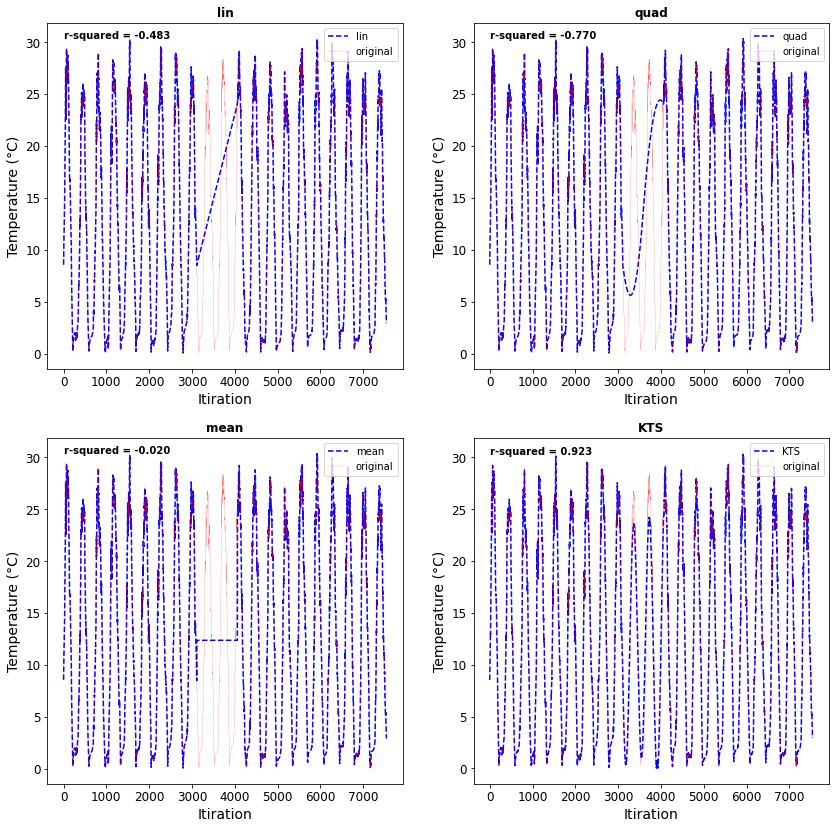

In [15]:
count=1
plt.subplots(figsize=(14, 14))

for idx, i_M in enumerate(imput_method):
    exec(f'X_t = X_{i_M}.EpiTemp')
    exec(f'r2 = r2_{i_M}_EpiTemp')
    plt.subplot(2,2,count)
    plt.plot(X_t, '--',c='blue', label = (imput_method[idx]))
    plt.plot(y_train.EpiTemp, '--',c='red', label = 'original',linewidth = 0.2)
    plt.annotate("r-squared = {:.3f}".format(r2), (0, max(X_t)),weight='bold')
    plt.xlabel('Itiration')
    plt.ylabel('Temperature (°C)')
    plt.title(i_M,fontweight="bold")
    plt.legend(loc = 'upper right')
    count+=1
   
        


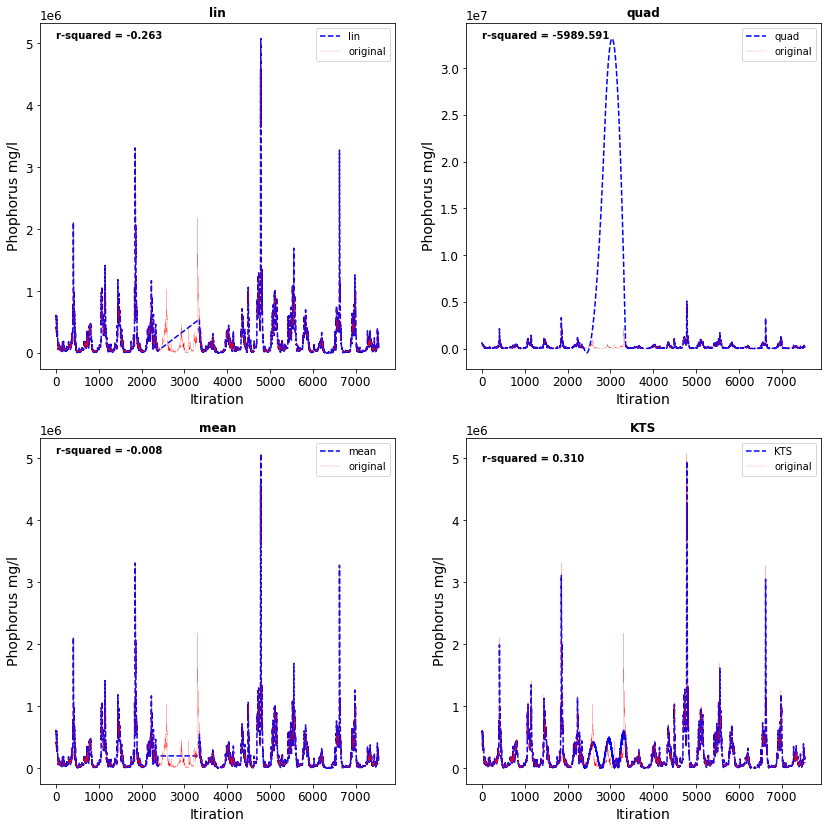

In [16]:
# Imputation method visulization
count=1
plt.subplots(figsize=(14, 14))

for idx, i_M in enumerate(imput_method):
    exec(f'X_t = X_{i_M}.PLoad')
    exec(f'r2 = r2_{i_M}_PLoad')
    plt.subplot(2,2,count)
    plt.plot(X_t, '--',c='blue', label = (imput_method[idx]))
    plt.plot(y_train.PLoad, '--',c='red', label = 'original',linewidth = 0.2)   
    plt.annotate("r-squared = {:.3f}".format(r2), (0, max(X_t)),weight='bold')
    plt.xlabel('Itiration')
    plt.ylabel('Phophorus mg/l')
    plt.title(i_M,fontweight="bold")
    plt.legend()
    count+=1                                          

## Machine learning model for all imputation method

GRU -Recurrent Neural Network

In [2]:
# Import files that beggings with X_
files = glob.glob("X_*.csv")

for f in files:
    n = f[2:-4] # method name
    exec(f'df_{n} =pd.read_csv(f)')
    print(f'df_{n}',eval(f'df_{n}.shape'))

df_KTS (7542, 11)
df_lin (7542, 11)
df_mean (7542, 11)
df_quad (7542, 11)
df_ref (7542, 11)


In [3]:
def get_df_name(data):    
    # To get names from lit of dataframes
    if isinstance(data, list): # if 
        name = []
        for d in data:
            n = [x for x in globals() if globals()[x] is d][0]
            name.append(n)
        return name
    # To get name from single dataframe
    else: 
        name =[x for x in globals() if globals()[x] is data][0]
        return name

data = [df_lin,df_quad,df_mean,df_KTS,df_ref]
data_n = get_df_name(data)
data_n

['df_lin', 'df_quad', 'df_mean', 'df_KTS', 'df_ref']

In [4]:
# Scaling data since LSTM use activation function (tanh/sigmoid) sensitive to the value's magnitudes of the variables

# Scale de data

scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = pd.DataFrame(scaler.fit_transform((df_ref.iloc[:7200,-1].to_numpy()).reshape(-1,1)))
label = y_scaled.astype('float32') #.to_numpy().reshape(-1,1) # 'Labels'

for idx,d in enumerate(data):
    m_n= (data_n[idx]).split('_')[1] # method name 
    data = d.iloc[:7200,1:9]
    exec(f'X{m_n}_scaled = pd.DataFrame(scaler.fit_transform(data))')
    # Split data into feature and label
    dt = 'float32'
    exec(f'features_{m_n} = X{m_n}_scaled.astype(dt)') # Training data
    print(f'features_{m_n}')
    

features_lin
features_quad
features_mean
features_KTS
features_ref


In [5]:
# Reshaping data into n_samples x timestep to be feed into the GRU netwok
def Reshape_df(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values) # Independent variable
        ys.append(y.iloc[i + time_steps].values) # Dependent variable
    return np.array(Xs), np.array(ys)

# Reshaping each imputated method df
data = [df_lin,df_quad,df_mean,df_KTS,df_ref]
data_n = get_df_name(data)

for idx,d in enumerate(data):
    m_n= (data_n[idx]).split('df_')[1] # method name 
    #print(f'features_{m_n}')
    exec(f'X_{m_n}, y_{m_n} = Reshape_df(features_{m_n}, label, 100)')
    print(f'X_{m_n}, y_{m_n}')

X_lin, y_lin
X_quad, y_quad
X_mean, y_mean
X_KTS, y_KTS
X_ref, y_ref


In [6]:
# Split data into train and test set for each imputation method

s = 0.8309
split = int(s*X_ref.shape[0])
y_train = y_ref[:split,:]
y_test =  y_ref[split:,:]
for idx,d in enumerate(data):
    m_n= (data_n[idx]).split('_')[1]   
    exec(f'X{m_n}_train = X_{m_n}[:split,:,:]')    
    exec(f'X{m_n}_test =  X_{m_n}[split:,:,:]')

# Print it
sets = []
for idx,d in enumerate(data):
    m_n= (data_n[idx]).split('_')[1]    
    sets.append(eval(f'X{m_n}_train'))
    sets.append(eval(f'X{m_n}_test'))
    
sets_n = get_df_name(sets)

for idx,i in enumerate(sets):
    print(f'{sets_n[idx]}:',i.shape)

Xlin_train: (5899, 100, 8)
Xlin_test: (1201, 100, 8)
Xquad_train: (5899, 100, 8)
Xquad_test: (1201, 100, 8)
Xmean_train: (5899, 100, 8)
Xmean_test: (1201, 100, 8)
XKTS_train: (5899, 100, 8)
XKTS_test: (1201, 100, 8)
Xref_train: (5899, 100, 8)
Xref_test: (1201, 100, 8)


In [7]:
# Set RMSE as loss function
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
# define r2_score to use it as metric 
def r2_score_m(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1-(SS_res/(SS_tot+ K.epsilon())))

## Cross-validation to tune the GRU model
Using the reference data (data without nan values)


In [ ]:
# Importing lake variables

Pepi = pd.read_csv('Pepi_Mendota.csv')
Pepi['sampledate'] = pd.to_datetime(Pepi['sampledate'])
Pepi.set_index('sampledate',inplace = True)

# selectiing variabls
df = df[['EpiTemp', 'HypoTemp','Strat','Therm', 'EpiV', 'HypV', 'Discharge', 'AirTemp.C', 'ShortWave.W_m2', 'Rain.m',
       'WindSpeed.m_s','PLoad','ObsPepi']]

#Cutting dataframe to cut weird values
df = df.iloc[0:7200,0:18]

# Print varibales
print(* (f"{i}: {col}" for i,col in enumerate(df.columns)), sep='\n')

In [ ]:
# Scaling data since LSTM use activation function (tanh/sigmoid) sensitive to the value's magnitudes of the variables

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(df.iloc[:,0:12])
X_df =pd.DataFrame(X_scaled)
8
y_scaled = scaler.fit_transform((df.iloc[:,-1].to_numpy()).reshape(-1,1))
y_df =pd.DataFrame(y_scaled)

# Selecting features and label for training 

features = X_df.astype('float32') # Training data
features[2] = features[2].astype(int)
label = y_df.astype('float32')#.to_numpy().reshape(-1,1) # 'Labels'

In [ ]:
# Reshaping data into n_samples x timestep to be feed into the GRU netwok
def Reshape_df(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X, y = Reshape_df(features, label, 100)

print(X.shape,y.shape)

In [8]:
# Split data into train and test set
s = 0.8309
split = int((s)*X.shape[0])
X_train = X[:split,:,:]
y_train = y[:split,:]
X_test =  X[split:,:,:]
y_test =  y[split:,:]

sets = [X_train, X_test, y_train, y_test]
sets_n = ['X_train', 'X_test', 'y_train', 'y_test']

for i,im in enumerate(sets):
    print(f'{sets_n[i]}:',im.shape)

In [2]:
# Set RMSE as loss function
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

Run cross-validation to tune the GRU model

In [35]:
keras.backend.clear_session()
tf.random.set_seed(rnd_seed)
np.random.seed(rnd_seed)

# Define per-fold score containers
r2_per_fold = []
loss_per_fold = []
rmse_per_fold = []
gru_hist = pd.DataFrame()
gru_best_score = []

kfold = KFold(n_splits=6)

fold_no = 1

# GRU model with Cross-validation

for train, val in kfold.split(X_train, y_train):
    # Initilize GRU model
    GRUmodel = keras.Sequential()

    # Input layer
    GRUmodel.add(Input(shape=(X_train.shape[1],X_train.shape[2]),
                       name='input_layer'))
    
    # Hidden layer
    GRUmodel.add(GRU (units = 100,#    from 100, 110 vs 120 
                      activation='relu', #relu vs  elu
                      dropout = 0.15, # 0.1, 0.15 vs 0.2
                      name = 'Hidden_layer'))
    
    # Output layer
    GRUmodel.add(Dense(units = 1,                       
                       name = 'Output_layer'))
        
    #Compile model
    GRUmodel.compile(optimizer=Adam(learning_rate=0.00001),loss= rmse,metrics=[RootMeanSquaredError()]) #,r2_score_m
    
    # Model check  point and  early_stopping 
    mchpt = tf.keras.callbacks.ModelCheckpoint(filepath=f'gru_{fold_no}_fold.ckpt',monitor = 'val_loss' ,save_best_only=True,mode ='min', verbose =0)#,save_weights_only=True) restore_best_weights = True
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5, mode ='min',verbose =0) # try patience of 3 or moin
    
    # Fit the model
    gru_h = GRUmodel.fit(X_train[train], y_train[train],validation_data=(X_train[val], y_train[val]),epochs = 100, batch_size =64,shuffle = False, callbacks = [early_stopping,mchpt]) 
    
    # Generalization metrics
    scores = GRUmodel.evaluate(X_train[val], y_train[val], verbose=0)
    
    # Perfromance metric
    y_p = GRUmodel.predict(X_test) # To record how model of each fold perform on the X_test
    r2_per_fold.append(r2_score(y_test,y_p)) # y_test = y_observed
    
    # Saving training and validation loss for each fold
    rmse_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])      
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()   
    gru_hist = gru_hist.append(gru_h.history,ignore_index=True) ###### !!!!!!!!!!! ...model_election ;)
    gru_best_score.append(mchpt.best)  
    
    # Print Result at each fold    
    print(f'Score for fold {fold_no}: {GRUmodel.metrics_names[0]} of {scores[0]:.2f}; {GRUmodel.metrics_names[1]} of {scores[1]:.2%}, r2_score: {r2_per_fold[fold_no-1]:.2%}')
    
    # Increase fold number
    fold_no = fold_no + 1
    
    # save model
    #m = f'GRU_f{fold_no-1}'
    #exec(f'GRUmodel.save(m)')

# Clear cross-validation output for each epoch to then print a clear summary of the Kfold :)
clear_output(wait=True) 

# == Print Model information (summary and scores) ==
print(' ')
print('                    ' + '\033[4m'+'\033[1m' + 'CV results for GRUmodel:'+ '\033[0m'+'\033[0m')
print(' ')
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print(' ')
print('                       ' +'\033[4m'+'\033[1m' + 'GRUmodel summary:'+ '\033[0m'+'\033[0m')
print(' ')
print(GRUmodel.summary())
print(' ')
#print('------------------------------------------------------------------------')
#print('------------------------------------------------------------------------')
print('                       ' +'\033[4m'+'\033[1m' + 'GRUmodel scores:'+ '\033[0m'+'\033[0m')
print(' ')
print('\033[1m'+'Score per fold'+ '\033[0m')
print(' ')
for i in range(0, len(loss_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - R2_score: {r2_per_fold[i]:.2%} - RMSE:{np.mean(rmse_per_fold[i]):.2f} - Loss: {loss_per_fold[i]:.2f}')
print(' ')
print('\033[1m' +'Average scores for all folds:'+ '\033[0m')
print(f'> R2_score:{np.mean(r2_per_fold):.2%} (+- {np.std(r2_per_fold):.2%})')
print(f'> RMSE:{np.mean(rmse_per_fold):.2f}')
print(f'> Loss:{np.mean(loss_per_fold):.2f}')
print(' ')
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')

 
                    CV results for GRUmodel:
 
------------------------------------------------------------------------
------------------------------------------------------------------------
 
                       GRUmodel summary:
 
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer (GRU)          (None, 100)               33000     
                                                                 
 Output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 33,101
Trainable params: 33,101
Non-trainable params: 0
_________________________________________________________________
None
 
                       GRUmodel scores:
 
Score per fold
 
------------------------------------------------------------------------
> Fold 1 - R2_score: 68.88% - RMSE:0.13 - Loss: 0.11
--------------

Code source: The previous code was build base on the foollows sources:

https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md

https://www.kaggle.com/code/barteksadlej123/lstm-vs-gru-with-cross-validation/notebook

Print cross validation results

C:\Users\gabri\AppData\Local\Temp/ipykernel_1944/1236809176.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(n_folds/2,n_folds/2,count)


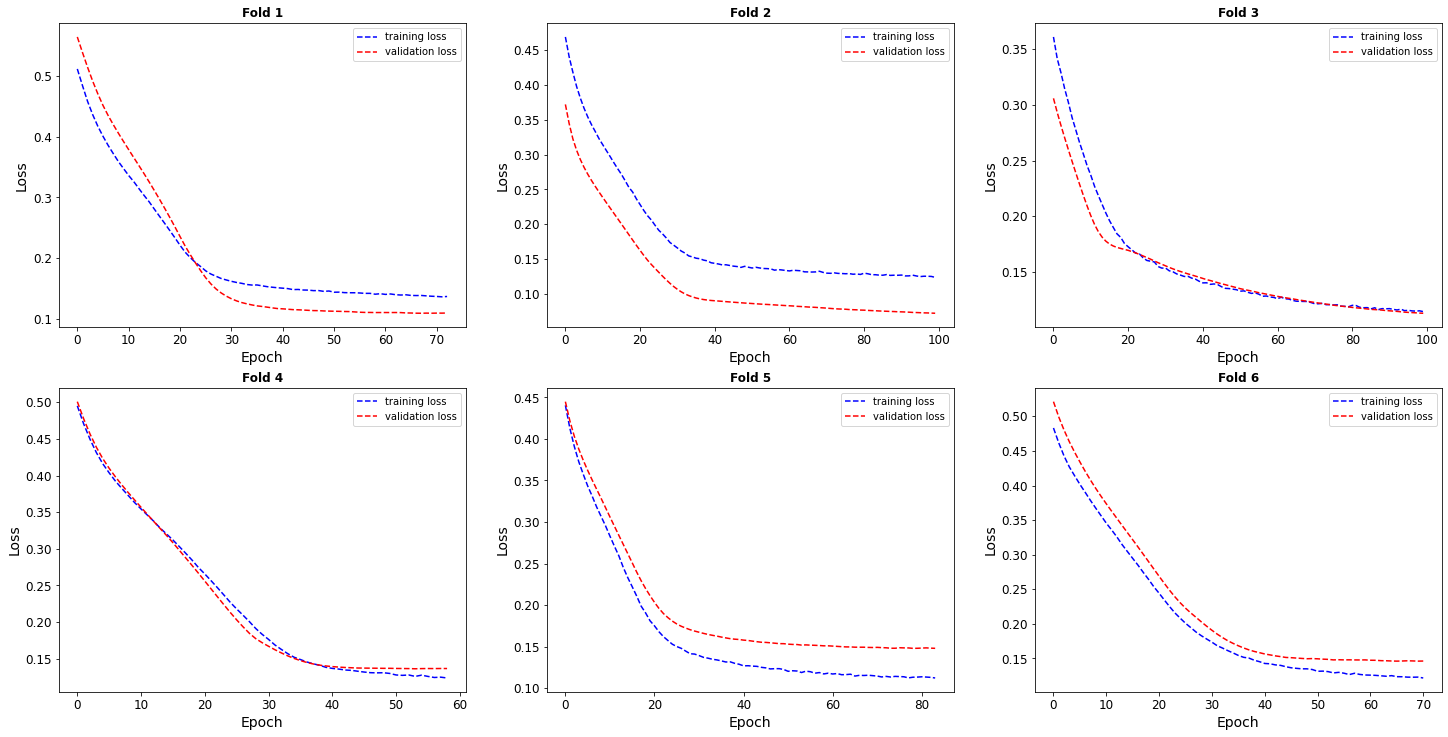

In [36]:
# Print val and train loss for each fold

count = 1
n_folds = 6

fig,ax = plt.subplots(figsize=(20,15))
fig.tight_layout() 

for i in range(n_folds):
    
    plt.subplot(n_folds/2,n_folds/2,count)
    plt.plot(gru_hist['loss'][i],'b--', label = 'training loss')
    plt.plot(gru_hist['val_loss'][i],'r--', label ='validation loss')
    #plt.plot(gru_hist['val_root_mean_squared_error'][i],'k-', label = 'val_RMSE')
    plt.title('Fold '+str(i+1),fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()  
    count+=1
#plt.subplots_adjust(top =1.2, bottom = 0.35)

# Applying the model post CV to each Imputation method 

° Considering the most optimum epoch number

In [3]:
# Import reference and imputation data features (X)
files = glob.glob("X_*.csv")
for f in files:
    n = f[2:-4] # method name
    exec(f'df_{n} =pd.read_csv(f)')
    print(f'df_{n}',eval(f'df_{n}.shape'))

df_KTS (7542, 11)
df_lin (7542, 11)
df_mean (7542, 11)
df_quad (7542, 11)
df_ref (7542, 11)


In [4]:
def get_df_name(data):    
    # To get names from lit of dataframes
    if isinstance(data, list): # if 
        name = []
        for d in data:
            n = [x for x in globals() if globals()[x] is d][0]
            name.append(n)
        return name
    # To get name from single dataframe
    else: 
        name =[x for x in globals() if globals()[x] is data][0]
        return name

data = [df_lin,df_quad,df_mean,df_KTS,df_ref]
data_n = get_df_name(data)
data_n

['df_lin', 'df_quad', 'df_mean', 'df_KTS', 'df_ref']

In [5]:
# Scaling data since LSTM use activation function (tanh/sigmoid) sensitive to the value's magnitudes of the variables

# Scale de data

scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = pd.DataFrame(scaler.fit_transform((df_ref.iloc[:7200,-1].to_numpy()).reshape(-1,1)))
label = y_scaled.astype('float32') #.to_numpy().reshape(-1,1) # 'Labels'

for idx,d in enumerate(data):
    m_n= (data_n[idx]).split('_')[1] # method name 
    data = d.iloc[:7200,1:9]
    exec(f'X{m_n}_scaled = pd.DataFrame(scaler.fit_transform(data))')
    # Split data into feature and label
    dt = 'float32'
    exec(f'features_{m_n} = X{m_n}_scaled.astype(dt)') # Training data
    print(f'features_{m_n}')
    

features_lin
features_quad
features_mean
features_KTS
features_ref


In [6]:
# Reshaping data into n_samples x timestep to be feed into the GRU netwok
def Reshape_df(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values) # Independent variable
        ys.append(y.iloc[i + time_steps].values) # Dependent variable
    return np.array(Xs), np.array(ys)

# Reshaping each imputated method df
data = [df_lin,df_quad,df_mean,df_KTS,df_ref]
data_n = get_df_name(data)

for idx,d in enumerate(data):
    m_n= (data_n[idx]).split('df_')[1] # method name 
    #print(f'features_{m_n}')
    exec(f'X_{m_n}, y_{m_n} = Reshape_df(features_{m_n}, label, 100)')
    print(f'X_{m_n}, y_{m_n}')

X_lin, y_lin
X_quad, y_quad
X_mean, y_mean
X_KTS, y_KTS
X_ref, y_ref


In [7]:
# Split data into train and test set for each imputation method

s = 0.8309
split = int(s*X_ref.shape[0])
y_train = y_ref[:split,:]
y_test =  y_ref[split:,:]
for idx,d in enumerate(data):
    m_n= (data_n[idx]).split('_')[1]   
    exec(f'X{m_n}_train = X_{m_n}[:split,:,:]')    
    exec(f'X{m_n}_test =  X_{m_n}[split:,:,:]')

# Print it
sets = []
for idx,d in enumerate(data):
    m_n= (data_n[idx]).split('_')[1]    
    sets.append(eval(f'X{m_n}_train'))
    sets.append(eval(f'X{m_n}_test'))
    
sets_n = get_df_name(sets)

for idx,i in enumerate(sets):
    print(f'{sets_n[idx]}:',i.shape)

Xlin_train: (5899, 100, 8)
Xlin_test: (1201, 100, 8)
Xquad_train: (5899, 100, 8)
Xquad_test: (1201, 100, 8)
Xmean_train: (5899, 100, 8)
Xmean_test: (1201, 100, 8)
XKTS_train: (5899, 100, 8)
XKTS_test: (1201, 100, 8)
Xref_train: (5899, 100, 8)
Xref_test: (1201, 100, 8)


In [8]:
# Generate a pair list of train and test method to 
it = iter(sets_n )
pair_set = list(zip(it, it))
pair_set

[('Xlin_train', 'Xlin_test'),
 ('Xquad_train', 'Xquad_test'),
 ('Xmean_train', 'Xmean_test'),
 ('XKTS_train', 'XKTS_test'),
 ('Xref_train', 'Xref_test')]

Now let's creat a function that make the same cross-validation as before but considering the final model for the orignial data plus the optimal Epoch numbers for each fold 
and applicate for each dataframe

In this way, we need a function that take into the name,X_train, y_train and X_test of each imputate method data
and E taht contain the choosen epoch number

In [8]:
def CV_GRU(E,name,X_train, y_train,X_test):
    # Define per-fold score containers
    r2_per_fold = []
    loss_per_fold = []
    rmse_per_fold = []
    gru_hist = pd.DataFrame()
    gru_best_score = []
    kfold = KFold(n_splits=6)

    fold_no = 1

    # GRU model with Cross-validation

    for train, val in kfold.split(X_train, y_train):
        # Initilize GRU model
        GRUmodel = keras.Sequential()

        # Input layer
        GRUmodel.add(Input(shape=(X_train.shape[1],X_train.shape[2]),
                           name='input_layer'))

        # Hidden layer
        GRUmodel.add(GRU (units = 100,#    from 100, 110 vs 120 
                          activation='relu', #relu vs  elu
                          dropout = 0.15, # 0.1, 0.15 vs 0.2
                          name = 'Hidden_layer'))

        # Output layer
        GRUmodel.add(Dense(units = 1,                       
                           name = 'Output_layer'))

        #Compile model
        GRUmodel.compile(optimizer=Adam(learning_rate=0.00001),loss= rmse,metrics=[RootMeanSquaredError()]) #,r2_score_m

        # Model check  point and  early_stopping 
        mchpt = tf.keras.callbacks.ModelCheckpoint(filepath=f'GRU_{name}/gru_{fold_no}_fold.ckpt',monitor = 'val_loss' ,save_best_only=True,mode ='min', verbose =0)#,save_weights_only=True) restore_best_weights = True
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5, mode ='min',verbose =0) # try patience of 3 or moin

        # Fit the model
        gru_h = GRUmodel.fit(X_train[train], y_train[train],validation_data=(X_train[val], y_train[val]),epochs = E[fold_no-1], batch_size =64,shuffle = False, callbacks = [early_stopping,mchpt]) 

        # Generalization metrics
        scores = GRUmodel.evaluate(X_train[val], y_train[val], verbose=0)

        # Perfromance metric
        y_p = GRUmodel.predict(X_test) # To record how model of each fold perform on the X_test
        r2_per_fold.append(r2_score(y_test,y_p)) # y_test = y_observed

        # Saving training and validation loss for each fold
        rmse_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])      
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()   
        gru_hist = gru_hist.append(gru_h.history,ignore_index=True) ###### !!!!!!!!!!! ...model_election ;)
        gru_best_score.append(mchpt.best)  

        # Print Result at each fold    
        print(f'Score for fold {fold_no}: {GRUmodel.metrics_names[0]} of {scores[0]:.2f}; {GRUmodel.metrics_names[1]} of {scores[1]:.2%}, r2_score: {r2_per_fold[fold_no-1]:.2%}')

        # Increase fold number
        fold_no = fold_no + 1

        # save model
        #m = f'GRU_f{fold_no-1}'
        #exec(f'GRUmodel.save(m)')

    # Clear cross-validation output for each epoch to then print a clear summary of the Kfold :)
    clear_output(wait=True) 

    # == Print Model information (summary and scores) ==
    print(' ')
    print('                    ' + '\033[4m'+'\033[1m' + 'CV results for GRUmodel:'+ '\033[0m'+'\033[0m')
    print(' ')
    print('------------------------------------------------------------------------')
    print('------------------------------------------------------------------------')
    print(' ')
    print('                       ' +'\033[4m'+'\033[1m' + 'GRUmodel summary:'+ '\033[0m'+'\033[0m')
    print(' ')
    print(GRUmodel.summary())
    print(' ')
    #print('------------------------------------------------------------------------')
    #print('------------------------------------------------------------------------')
    print('                       ' +'\033[4m'+'\033[1m' + 'GRUmodel scores:'+ '\033[0m'+'\033[0m')
    print(' ')
    print('\033[1m'+'Score per fold'+ '\033[0m')
    print(' ')
    for i in range(0, len(loss_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - R2_score: {r2_per_fold[i]:.2%} - RMSE:{np.mean(rmse_per_fold[i]):.2f} - Loss: {loss_per_fold[i]:.2f}')
    print(' ')
    print('\033[1m' +'Average scores for all folds:'+ '\033[0m')
    print(f'> R2_score:{np.mean(r2_per_fold):.2%} (+- {np.std(r2_per_fold):.2%})')
    print(f'> RMSE:{np.mean(rmse_per_fold):.2f}')
    print(f'> Loss:{np.mean(loss_per_fold):.2f}')
    print(' ')
    print('------------------------------------------------------------------------')
    print('------------------------------------------------------------------------')
    return(GRUmodel)

In [9]:
# Generate a pair list of train and test method to 
it = iter(sets_n )
pair_set = list(zip(it, it))
pair_set

# Apply the CV_GRU for each method and the best epoch of original data and save it in a folder
E = [100,100,100,35,25,35]
for idx,i in enumerate(data_n):
    m_n= ((data_n[idx]).split('_')[1])
    X_train = eval(pair_set[idx][0])
    X_test = eval(pair_set[idx][1])    
    exec(f'GRU_{m_n} = CV_GRU(E,m_n,X_train, y_train,X_test )')

 
                    CV results for GRUmodel:
 
------------------------------------------------------------------------
------------------------------------------------------------------------
 
                       GRUmodel summary:
 
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer (GRU)          (None, 100)               33000     
                                                                 
 Output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 33,101
Trainable params: 33,101
Non-trainable params: 0
_________________________________________________________________
None
 
                       GRUmodel scores:
 
Score per fold
 
------------------------------------------------------------------------
> Fold 1 - R2_score: 74.26% - RMSE:0.12 - Loss: 0.10
-------------

In [11]:
# Import reference and imputation data features (X)
co = {'rmse':rmse } # custom_objects

for n in data_n:
    m_n = (n.split('_')[1]) # method name
    temp_path =(f"GRU_{m_n}/*.ckpt") # Place Holder for folder name that contain the cv reult
    exec(f'files = glob.glob(temp_path)')
    exec(f'y_pred_{m_n}_CV= np.zeros(shape=(X{m_n}_test.shape[0],1))') 
    for i,f in enumerate(files):
        exec(f'GRU_{m_n}_f{i+1} = load_model(f,custom_objects=co)') # load each fold model
        exec(f'X_pred_{m_n}_f{i+1} = GRU_{m_n}_f{i+1}.predict(X{m_n}_test)')
        y_pred =eval(f'X_pred_{m_n}_f{i+1}.reshape(-1,1)')
        exec(f'y_pred_{m_n}_CV = np.concatenate((y_pred_{m_n}_CV, y_pred), axis=1)')
    # Calculate average metric for each method
   
    temp_mean = eval(f'np.mean(y_pred_{m_n}_CV[:,1:], axis = 1)')
    exec(f'y_pred_{m_n}_mean = temp_mean.reshape(-1,1)')
    exec(f'r2_score_{m_n}= r2_score(y_test,y_pred_{m_n}_mean)')
    exec(f'rmse_{m_n}= mean_squared_error(y_test,y_pred_{m_n}_mean, squared = False)')
    exec(f'mae_{m_n}= mean_absolute_error(y_test,y_pred_{m_n}_mean)') 
    print(f'CV average prediction: {m_n} [DONE]')

CV average prediction: lin [DONE]
CV average prediction: quad [DONE]
CV average prediction: mean [DONE]
CV average prediction: KTS [DONE]
CV average prediction: ref [DONE]


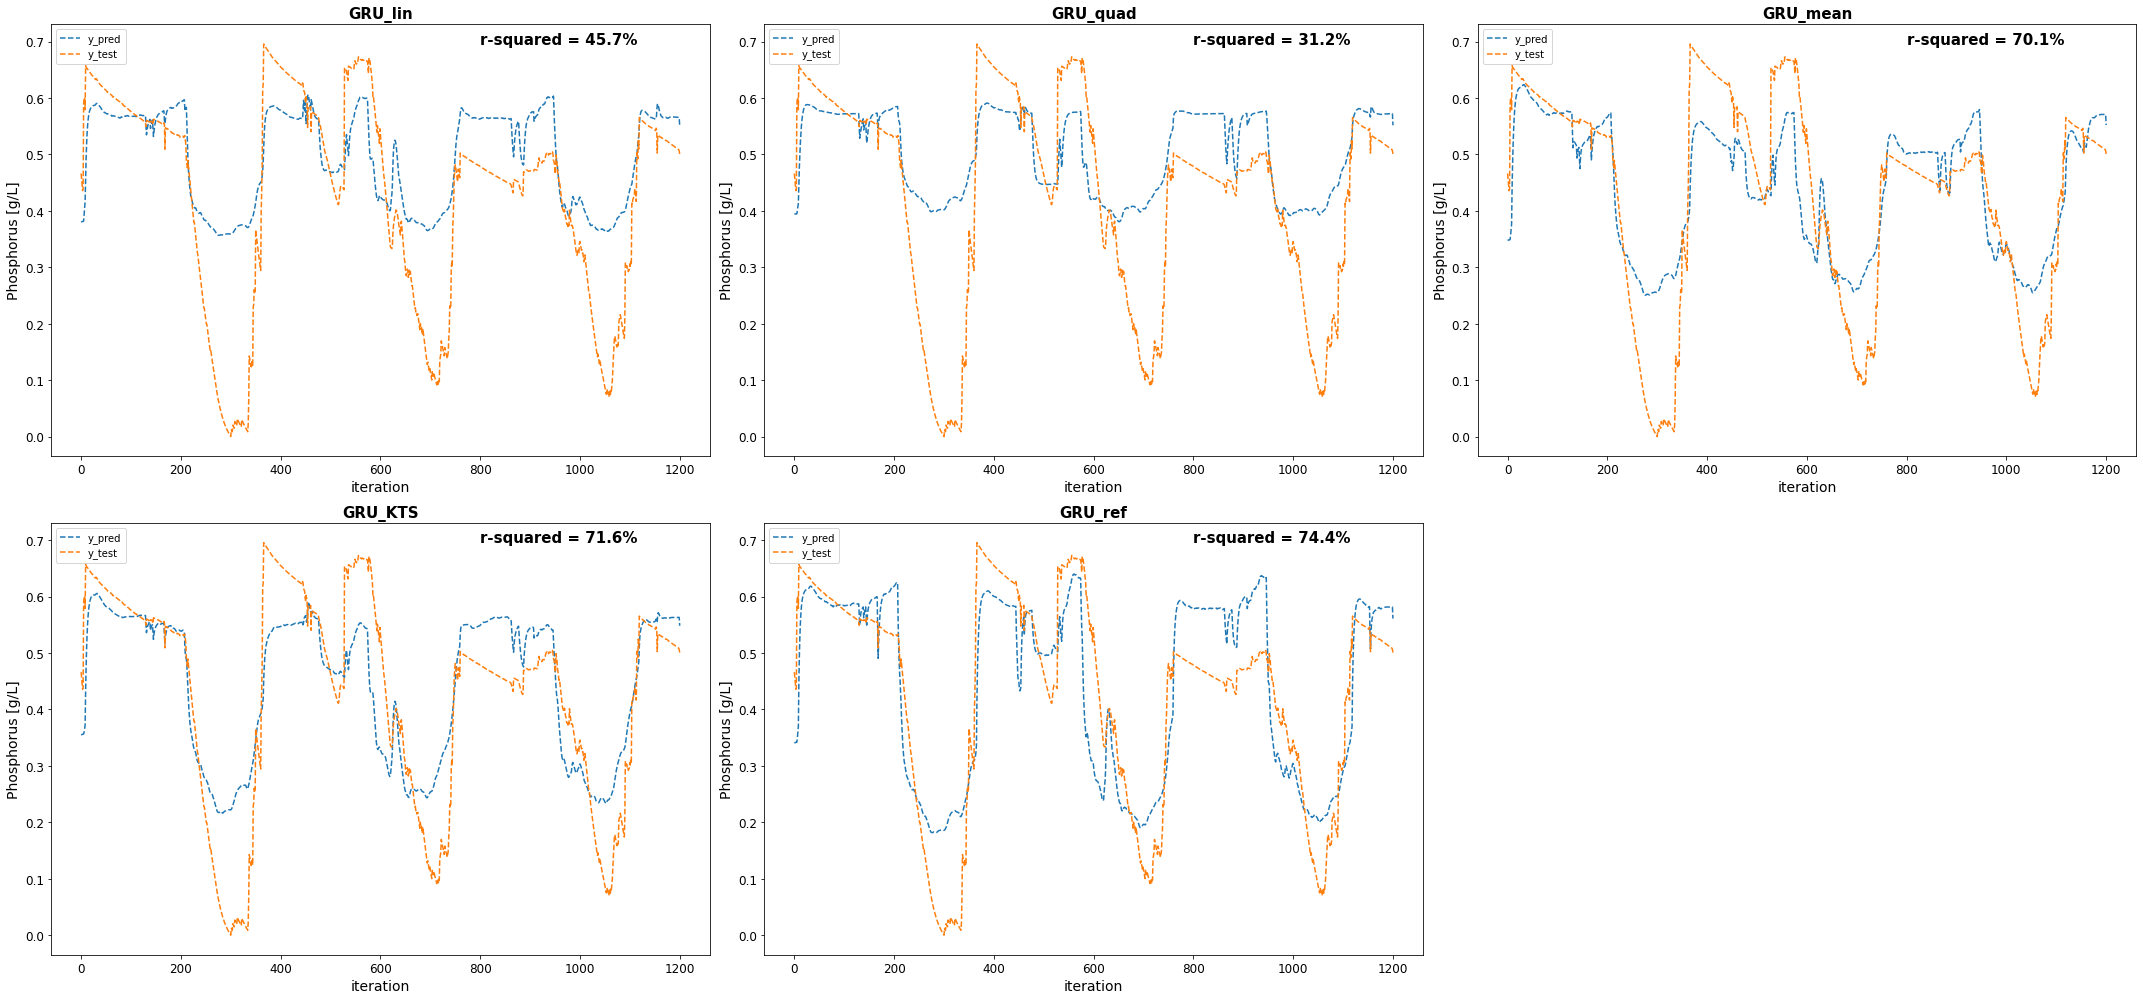

In [35]:
count= -1 
metrics = [] # Save imputation performance for the Na section for each column

fig, axs = plt.subplots(2,3, figsize=(30, 14), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

y_obs = y_test # Original feature (reference data)

# Plot KTS imputation for each featur limited to the nan window
for n in data_n:
    m_n = (n.split('_')[1]) # method name
    count += 1
    exec(f'y_pred = y_pred_{m_n}_mean') # feature imputed by KTS    
    axs[count].plot(y_pred,'--', label = 'y_pred') # Imputated data
    axs[count].plot(y_obs, '--', label = 'y_test') # Data with Nan's   ,linewidth = 0.3 
    axs[count].annotate("r-squared = {:.1%}".format(eval(f'r2_score_{m_n}')), (800, max(y_obs)),weight='bold',fontsize=15);
    axs[count].set_xlabel('iteration')
    axs[count].set_ylabel('Phosphorus [g/L]')
    axs[count].set_title('GRU_'+m_n,fontweight="bold",fontsize=15)
    axs[count].legend(loc = 'upper left')

fig.tight_layout() 

# Remove empty plot 
for j in range(len(data_n),3*2):
    axs[j].axis("off")

In [28]:
ind = []
col = ['r2_score','rmse','mae']
metric = []
for i , n in enumerate (data_n):
    m_n = (n.split('_')[1]) # method name
    ind.append(m_n)    
    
    r2 = eval(f'r2_score_{m_n}')
    rmsei =eval(f'rmse_{m_n}')
    mae =eval(f'mae_{m_n}')
    metric.append({
        'r2':r2,
        'Method':m_n.capitalize(),
        'MAE':mae,
        'RMSE':rmsei
    })

In [32]:
met =pd.DataFrame(metric).set_index('Method').sort_values(by = 'MAE', ascending = True)

for c in met.columns:
    if c =='r2':
        met[c]=met[c].map('{:,.2%}'.format)
    else:
        met[c]=met[c].map('{:,.2f}'.format)
met

,r2,MAE,RMSE
Method,,,
Ref,74.40%,0.08,0.09
Mean,70.11%,0.08,0.10
Kts,71.57%,0.08,0.10
Lin,45.69%,0.10,0.14
Quad,31.18%,0.11,0.15
